# Unit Simulation Experimental Notebook

In [1]:
from IPython.display import HTML
%matplotlib inline
# our simulator
import matplotlib.pyplot as plt
import battlesim as bsm

### Trial 1. 50 Clone Troopers vs. 80 B1 battledroids

Using Random AI selection for targets.

In [2]:
trial1 = bsm.Battle("datasets/starwars-clonewars.csv")
# define 100 battledroids, 50 clones
trial1.create_army([("b1 battledroid", 80), ("Clone Trooper", 20), ("Clone Trooper", 15)])
# battle droids near (0, 0), clones near (10, 10)
trial1.apply_position([
    dict(name="uniform", x_loc=-5., scale=2.),
    dict(name="gaussian", loc=0.),
    dict(name="gaussian", x_loc=4., y_loc=5.),
])
#init, rolling AIs now default to 'nearest'
trial1.set_decision_ai(["aggressive","hit_and_run","hit_and_run"])
# set terrain
t1_terra = bsm.Terrain((-10., 20., -10., 20.), res=.5, form="contour", dtype="perlin")
trial1.apply_terrain(t1_terra)

bsm.Battle(init=True, n_armies=3, simulated=False)

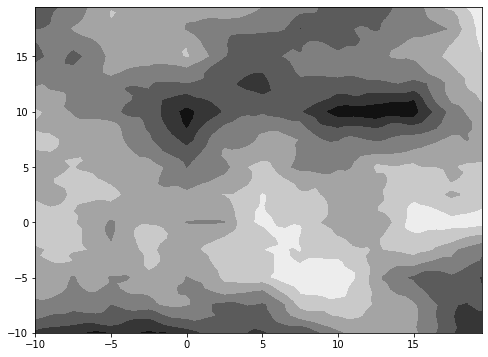

In [3]:
t1_terra.generate().plot()

In [4]:
# run a battle
F = trial1.simulate(max_step=1500)

In [5]:
F.memory_usage()

Index         57040
army           7130
allegiance     7130
alive          7130
hp            28520
armor         28520
x             28520
y             28520
dir_x         28520
dir_y         28520
dtype: int64

In [6]:
F.memory_usage().sum()/1000000

0.24955

In [9]:
trial1.sim_export()

### Terrain tweaking

In [8]:
import numpy as np
from numba import njit, prange

In [9]:
@njit
def smooth_noise(noise, x, y, noisewidth=100, noiseheight=100):
    # get fractional part
    fractX = x - int(x)
    fractY = y - int(y)
    # wrap
    x1 = (int(x) + noisewidth) % noisewidth
    y1 = (int(y) + noiseheight) % noiseheight
    # neighbor values
    x2 = (x1 + noisewidth - 1) % noisewidth
    y2 = (y1 + noiseheight - 1) % noiseheight
    # smooth the noise with bilinear interpolation
    val = 0.
    val += fractX*fractY*noise[y1, x1]
    val += (1-fractX)*fractY*noise[y1, x2]
    val += fractX*(1-fractY)*noise[y2,x1]
    val += (1-fractX)*(1-fractY)*noise[y2,x2]
    return val

@njit
def turbulence(noise, x, y, size, dim_x, dim_y):
    val = 0.
    init_size = size
    while size >= 1:
        val += smooth_noise(noise, x / size, y / size, dim_x, dim_y) * size
        size /= 2.
    return 128 * val / init_size

In [10]:
@njit
def create_turbulence_map(dim_x, dim_y, size=30):
    """"""
    base_noise = np.random.rand(dim_x, dim_y)
    noise = np.random.rand(dim_x, dim_y)
    for x in range(dim_x):
        for y in range(dim_y):
            noise[x, y] = turbulence(base_noise, x, y, size, dim_x, dim_y)
    return noise

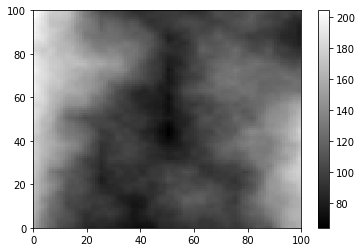

In [24]:
plt.pcolormesh(create_turbulence_map(100, 100, 50), cmap="gray")
plt.colorbar()

In [10]:
X, Y = np.mgrid[0:10:.1, 0:10:.1]
plt.contourf(X, Y, create_turbulence_map(100, 100), cmap="gray_r")

NameError: name 'np' is not defined